In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:

len(os.listdir('/kaggle/input/labeled-chest-xray-images/chest_xray/train/PNEUMONIA'))

In [1]:
!pip install torch-summary

In [2]:
import os
import cv2
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.image as maping
from PIL import Image
from IPython.display import display
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.optim.lr_scheduler import StepLR
from torchsummary import summary
from tqdm import tqdm
import numpy as np # linear algebra
import pandas as pd

# Data exploration

In [3]:
class_names = ["NORMAL", "PNEUMONIA"]
path =  '/kaggle/input/labeled-chest-xray-images/chest_xray'
def get_list_files(dirname):
    file_list = os.listdir(dirname)
    return file_list

files_list_normal_train = get_list_files(path+ "/train/" + class_names[0])
files_list_pneumonia_train = get_list_files(path+ "/train/" + class_names[1])
files_list_normal_test = get_list_files(path+ "/test/" + class_names[0])
files_list_pneumonia_test = get_list_files(path+ "/test/" + class_names[1])

In [4]:
print(f"the number of normal samples in the train dataset {len(files_list_normal_train)}")
print(f"the number of pneumonia samples in the train dataset {len(files_list_pneumonia_train)}")
print(f"the number of normal samples in the train dataset {len(files_list_normal_test)}")
print(f"the number of pneumonia samples in the train dataset {len(files_list_pneumonia_test)}")

the number of normal samples in the train dataset 1349
the number of pneumonia samples in the train dataset 3883
the number of normal samples in the train dataset 234
the number of pneumonia samples in the train dataset 390


# Displaying random images

image shape: (1048, 1272)
Normal


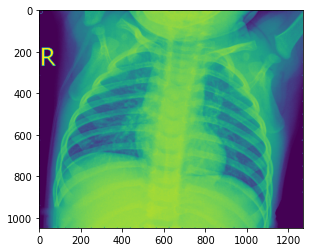

*************************************
image shape: (656, 1088)
Pneumonia


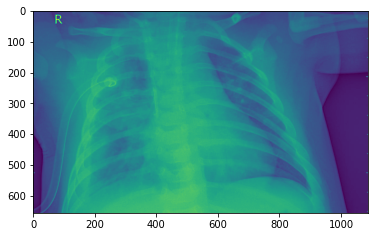

In [5]:

random_img = np.random.randint(0, len(files_list_normal_train))
img = path + "/train/NORMAL/" + files_list_normal_train[random_img]
print(f"image shape: {plt.imread(img).shape}")
print("Normal")
#display(Image.open(img, "r"))
img = maping.imread(img)
imgplot = plt.imshow(img)
plt.show()
print("*************************************")
random_img = np.random.randint(0, len(files_list_pneumonia_train))
img = path + "/train/PNEUMONIA/" + files_list_pneumonia_train[random_img]
print(f"image shape: {plt.imread(img).shape}")
print("Pneumonia")
#display(Image.open(img, "r"))
img = maping.imread(img)
imgplot = plt.imshow(img)
plt.show()

## Remarks on the data:
- data have 2 cateogries normal and pneumonia.
- the training data set has 3883 samples in the pneumonia category and 1349 in the normal category.
- the test set has 390 samples in pneumonia category and 234 in normal category.
- image sizes is not uniform, we need to standardize the images

# Data Transformations and building Dataloaders

In [6]:
train_transform = transforms.Compose([transforms.Resize(224), 
                                      transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], #mean
                                                          [0.299, 0.224, 0.255])]) # standard div

In [7]:
#same transform as the train for this project, but it's a good practice to use test transfor
test_transform = transforms.Compose([transforms.Resize(224), 
                                      transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], #mean
                                                          [0.299, 0.224, 0.255])]) # standard div

In [8]:
"""
using ImageFolder to make the dataset
ImageFolder expect the input data folders to be like ./train/class_name/img
"""
train_data = datasets.ImageFolder(os.path.join(path, "train"), transform = train_transform)
test_data = datasets.ImageFolder(os.path.join(path, "test"), transform = train_transform)

In [9]:
DataLoader_train = DataLoader(train_data, batch_size = 16,
                              shuffle = True, pin_memory= True)
DataLoader_test = DataLoader(test_data, batch_size = 1, 
                             shuffle = False, pin_memory = True)

# Building the model

In [10]:
class Convnet(nn.Module):
    def __init__(self):
        super(Convnet, self).__init__()
        #input blcok
        self.convblock1 = nn.Sequential( nn.Conv2d(in_channels = 3,
                                                   out_channels= 8, kernel_size=(3,3), 
                                                   padding = 0, bias = False),
                                       nn.ReLU())
        
        self.pool1 = nn.MaxPool2d(2,2)
        
        #convolution blok
        
        self.convblock2 = nn.Sequential( nn.Conv2d(in_channels = 8, out_channels = 16,
                                                  kernel_size = (3,3), padding = 0,
                                                  bias = False),
                                        nn.ReLU())
        
        # transation block to reduce the number of channels from 16 to 10
        
        self.pool22 = nn.MaxPool2d(2,2)
        
        self.convblock3 = nn.Sequential( nn.Conv2d(in_channels = 16, out_channels = 10
                                                   ,kernel_size = (1,1), 
                                                   padding = 0, bias = 0),
                                       nn.ReLU())
        
        self.pool33 = nn.MaxPool2d(2,2)
        
        self.convblock4 = nn.Sequential(nn.Conv2d(in_channels = 10, out_channels = 10, 
                                                 kernel_size = (3,3),
                                                  padding = 0, bias = 0),
                                       nn.ReLU())
        
        self.convblock5 = nn.Sequential(nn.Conv2d(in_channels = 10, out_channels = 32, 
                                                 kernel_size = (1,1),
                                                  padding = 0, bias = 0),
                                       nn.ReLU())
        
        self.convblock6 = nn.Sequential(nn.Conv2d(in_channels = 32, out_channels = 10, 
                                                 kernel_size = (1,1), 
                                                  padding = 0, bias = 0),
                                       nn.ReLU())
        self.convblock7 = nn.Sequential(nn.Conv2d(in_channels = 10, out_channels = 10, 
                                                 kernel_size = (3,3),
                                                  padding = 0, bias = 0),
                                       nn.ReLU())
        self.convblock8 = nn.Sequential(nn.Conv2d(in_channels = 10, out_channels = 32, 
                                                 kernel_size = (1,1),
                                                  padding = 0, bias = 0),
                                       nn.ReLU())
        
        self.convblock9 = nn.Sequential(nn.Conv2d(in_channels = 32, out_channels = 10, 
                                                 kernel_size = (1,1), 
                                                  padding = 0, bias = 0),
                                       nn.ReLU())
        
        self.convblock10 = nn.Sequential(nn.Conv2d(in_channels = 10, out_channels = 14, 
                                                 kernel_size = (3,3),
                                                   padding = 0, bias = 0),
                                       nn.ReLU())
        
        self.convblock11 = nn.Sequential(nn.Conv2d(in_channels = 14, out_channels = 16, 
                                                 kernel_size = (3,3),
                                                   padding = 0, bias = 0),
                                       nn.ReLU())
        
        #output block
        
        self.gap = nn.Sequential(nn.AvgPool2d(kernel_size = 4))
        
        self.convblockout = nn.Sequential(nn.Conv2d(in_channels = 16, out_channels = 2,
                                                   kernel_size = (4,4),
                                                    padding = 0, bias = False),
                                         )
        
        
    def forward(self, x):
        x = self.convblock1(x)
        x = self.pool1(x)
        x = self.convblock2(x)
        x = self.pool22(x)
        x = self.convblock3(x)
        x = self.pool33(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.convblock10(x)
        x = self.convblock11(x)
        x = self.gap(x)
        x = self.convblockout(x)
        
        x = x.view(-1, 2)
        return F.log_softmax(x, dim = 1)
        
        
        
        
        

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"available device {device}")

available device cuda


In [12]:
model = Convnet().to(device)
summary(model , input_data = (3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 8, 222, 222]         --
|    └─Conv2d: 2-1                       [-1, 8, 222, 222]         216
|    └─ReLU: 2-2                         [-1, 8, 222, 222]         --
├─MaxPool2d: 1-2                         [-1, 8, 111, 111]         --
├─Sequential: 1-3                        [-1, 16, 109, 109]        --
|    └─Conv2d: 2-3                       [-1, 16, 109, 109]        1,152
|    └─ReLU: 2-4                         [-1, 16, 109, 109]        --
├─MaxPool2d: 1-4                         [-1, 16, 54, 54]          --
├─Sequential: 1-5                        [-1, 10, 54, 54]          --
|    └─Conv2d: 2-5                       [-1, 10, 54, 54]          160
|    └─ReLU: 2-6                         [-1, 10, 54, 54]          --
├─MaxPool2d: 1-6                         [-1, 10, 27, 27]          --
├─Sequential: 1-7                        [-1, 10, 25, 25]          --
|    └─Con

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 8, 222, 222]         --
|    └─Conv2d: 2-1                       [-1, 8, 222, 222]         216
|    └─ReLU: 2-2                         [-1, 8, 222, 222]         --
├─MaxPool2d: 1-2                         [-1, 8, 111, 111]         --
├─Sequential: 1-3                        [-1, 16, 109, 109]        --
|    └─Conv2d: 2-3                       [-1, 16, 109, 109]        1,152
|    └─ReLU: 2-4                         [-1, 16, 109, 109]        --
├─MaxPool2d: 1-4                         [-1, 16, 54, 54]          --
├─Sequential: 1-5                        [-1, 10, 54, 54]          --
|    └─Conv2d: 2-5                       [-1, 10, 54, 54]          160
|    └─ReLU: 2-6                         [-1, 10, 54, 54]          --
├─MaxPool2d: 1-6                         [-1, 10, 27, 27]          --
├─Sequential: 1-7                        [-1, 10, 25, 25]          --
|    └─Con

## The training process

In [13]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []


In [73]:
def train(model , device , train_loader, optimizer , epoch):
    model.train()
    pbar = tqdm(DataLoader_train)
    correct = 0
    processed = 0
    for batch_idx, (data, targets) in enumerate(pbar):
        #intializing the gradient
        #forward pass
        data = data.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        y_pred = model(data)
        loss = F.nll_loss(y_pred, targets)
        train_losses.append(loss)
        
        #backward pass
        
        loss.backward()
        optimizer.step()
        pred = y_pred.argmax(dim = 1, keepdim = True)
        correct += pred.eq(targets.view_as(pred)).sum().item()
        processed += len(data)
        pbar.set_description( 
            desc = f"Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}")
        train_acc.append(100/correct/processed)
        
        

In [74]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, targets in test_loader:
            data = data.to(device)
            
            targets = targets.to(device)
            pred_y = model(data)
            test_loss += F.nll_loss(pred_y , targets, reduction = "sum").item()
            pred = pred_y.argmax(dim=1 , keepdim = True)
            correct += pred.eq(targets.view_as(pred)).sum().item()
            
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print(f"Test set Average loss: {test_loss:.4f}, Accuracy:{100 * correct/len(test_loader.dataset)}")
    
    test_acc.append(100. * correct / len(test_loader.dataset))
                  

In [16]:
model = Convnet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9)
scheduler = StepLR(optimizer, step_size = 6, gamma = 0.5)

epochs = 5
for epoch in range(epochs):
    print("Epoch:" , epoch)
    train(model, device, DataLoader_train, optimizer, epoch)
    scheduler.step()
    print("current Learning Rate:" , optimizer.state_dict()["param_groups"][0]["lr"])
    test(model, device, DataLoader_test)

Epoch: 0


Loss=0.6931 Batch_id=326 Accuracy=75.71: 100%|██████████| 327/327 [02:33<00:00,  2.13it/s]


current Learning Rate: 0.01
Test set Average loss: 0.6931, Accuracy:66.18589743589743
Epoch: 1


Loss=0.6931 Batch_id=326 Accuracy=75.59: 100%|██████████| 327/327 [01:58<00:00,  2.77it/s]


current Learning Rate: 0.01
Test set Average loss: 0.6931, Accuracy:65.38461538461539
Epoch: 2


Loss=0.6931 Batch_id=326 Accuracy=75.54: 100%|██████████| 327/327 [01:57<00:00,  2.77it/s]


current Learning Rate: 0.01
Test set Average loss: 0.6931, Accuracy:64.90384615384616
Epoch: 3


Loss=0.6931 Batch_id=326 Accuracy=75.55: 100%|██████████| 327/327 [01:57<00:00,  2.78it/s]


current Learning Rate: 0.01
Test set Average loss: 0.6931, Accuracy:64.58333333333333
Epoch: 4


Loss=0.6931 Batch_id=326 Accuracy=75.21: 100%|██████████| 327/327 [01:58<00:00,  2.76it/s]


current Learning Rate: 0.01
Test set Average loss: 0.6931, Accuracy:63.94230769230769


In [19]:
train_losses1 = [i.item() for i in train_losses]
train_acc1 = [i for i in train_acc]
test_losses1 = [i for i in test_losses]
test_acc1 = [i for i in test_acc]

Text(0.5, 1.0, 'test Accuracy')

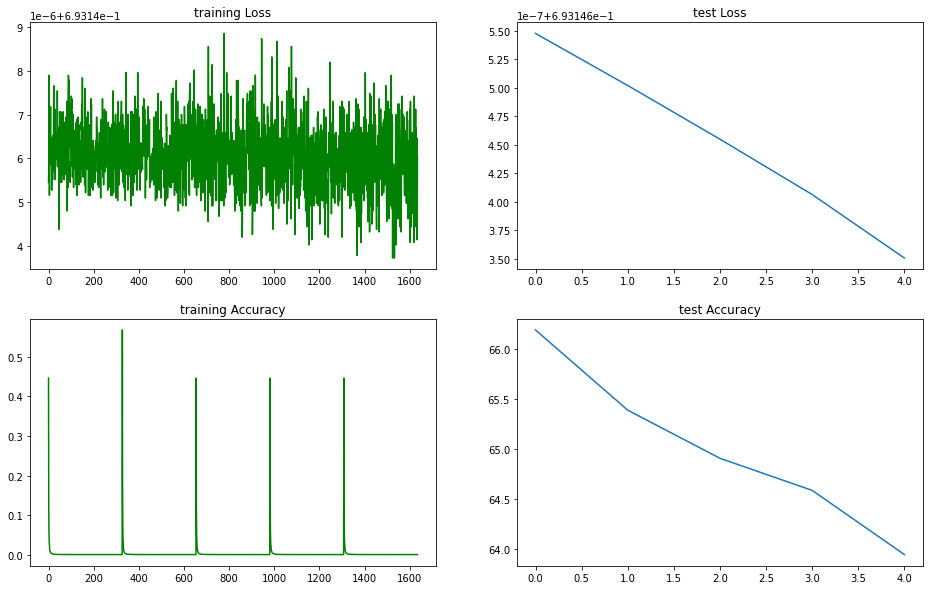

In [20]:
fig, axs = plt.subplots(2,2, figsize = (16, 10))
axs[0,0].plot(train_losses1, color = "green")
axs[0,0].set_title("training Loss")
axs[1,0].plot(train_acc1, color = "green")
axs[1,0].set_title("training Accuracy")
axs[0,1].plot(test_losses1)
axs[0,1].set_title("test Loss")
axs[1,1].plot(test_acc1)
axs[1,1].set_title("test Accuracy")







## Data augmantation 

In [68]:
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ColorJitter(brightness = 0.10, contrast = 0.1,
                          saturation = 0.1, hue = 0.1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                        [0.299, 0.224 , 0.255])

])

train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                        [0.299, 0.224 , 0.255])

])

In [69]:
"""
using ImageFolder to make the dataset
ImageFolder expect the input data folders to be like ./train/class_name/img
"""
train_data = datasets.ImageFolder(os.path.join(path, "train"), transform = train_transform)
test_data = datasets.ImageFolder(os.path.join(path, "test"), transform = train_transform)

In [70]:
DataLoader_train = DataLoader(train_data, batch_size = 16,
                              shuffle = True, pin_memory= True)
DataLoader_test = DataLoader(test_data, batch_size = 1, 
                             shuffle = False, pin_memory = True)

In [71]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

In [75]:
model = Convnet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9)
scheduler = StepLR(optimizer, step_size = 6, gamma = 0.5)

epochs = 5
for epoch in range(epochs):
    print("Epoch:" , epoch)
    train(model, device, DataLoader_train, optimizer, epoch)
    scheduler.step()
    print("current Learning Rate:" , optimizer.state_dict()["param_groups"][0]["lr"])
    test(model, device, DataLoader_test)

Epoch: 0


Loss=0.6931 Batch_id=326 Accuracy=26.68: 100%|██████████| 327/327 [01:58<00:00,  2.75it/s]


current Learning Rate: 0.01
Test set Average loss: 0.6931, Accuracy:38.14102564102564
Epoch: 1


Loss=0.6931 Batch_id=326 Accuracy=29.28: 100%|██████████| 327/327 [01:56<00:00,  2.80it/s]


current Learning Rate: 0.01
Test set Average loss: 0.6931, Accuracy:43.75
Epoch: 2


Loss=0.6931 Batch_id=326 Accuracy=41.88: 100%|██████████| 327/327 [01:57<00:00,  2.79it/s]


current Learning Rate: 0.01
Test set Average loss: 0.6931, Accuracy:57.8525641025641
Epoch: 3


Loss=0.6931 Batch_id=326 Accuracy=54.99: 100%|██████████| 327/327 [01:57<00:00,  2.77it/s]


current Learning Rate: 0.01
Test set Average loss: 0.6931, Accuracy:65.7051282051282
Epoch: 4


Loss=0.6931 Batch_id=326 Accuracy=64.11: 100%|██████████| 327/327 [01:57<00:00,  2.78it/s]


current Learning Rate: 0.01
Test set Average loss: 0.6931, Accuracy:71.63461538461539


In [76]:
train_losses2 = [i.item() for i in train_losses]
train_acc2 = [i for i in train_acc]
test_losses2 = [i for i in test_losses]
test_acc2 = [i for i in test_acc]

Text(0.5, 1.0, 'test Accuracy')

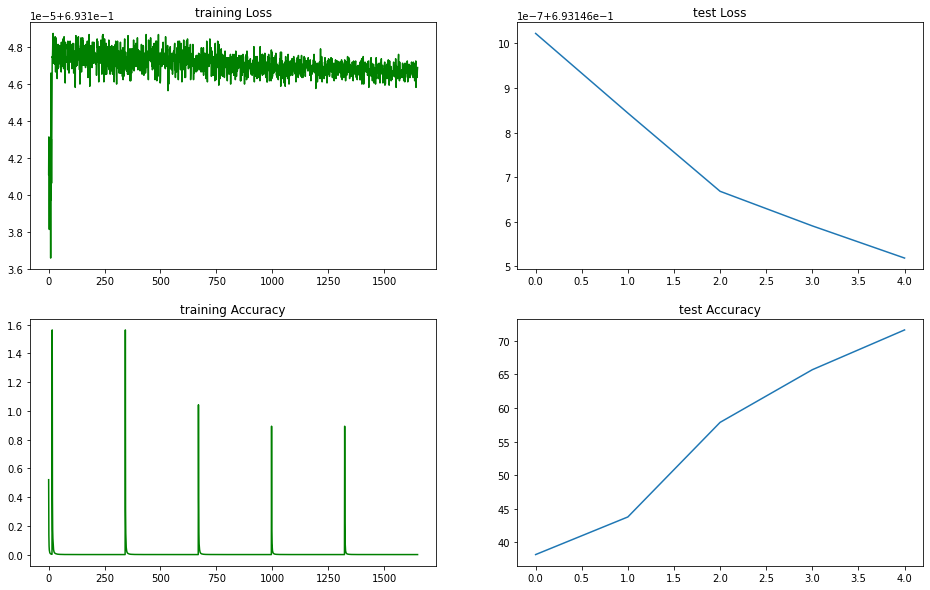

In [77]:
fig, axs = plt.subplots(2,2, figsize = (16, 10))
axs[0,0].plot(train_losses2, color = "green")
axs[0,0].set_title("training Loss")
axs[1,0].plot(train_acc2, color = "green")
axs[1,0].set_title("training Accuracy")
axs[0,1].plot(test_losses2)
axs[0,1].set_title("test Loss")
axs[1,1].plot(test_acc2)
axs[1,1].set_title("test Accuracy")

## Batch normalization

In [78]:
class Convnet(nn.Module):
    def __init__(self):
        super(Convnet, self).__init__()
        #input blcok
        self.convblock1 = nn.Sequential( nn.Conv2d(in_channels = 3,
                                                   out_channels= 8, kernel_size=(3,3), 
                                                   padding = 0, bias = False),
                                       nn.ReLU(), 
                                       nn.BatchNorm2d(8))
        
        self.pool1 = nn.MaxPool2d(2,2)
        
        #convolution blok
        
        self.convblock2 = nn.Sequential( nn.Conv2d(in_channels = 8, out_channels = 16,
                                                  kernel_size = (3,3), padding = 0,
                                                  bias = False),
                                        nn.ReLU(),
                                       nn.BatchNorm2d(16))
        
        # transation block to reduce the number of channels from 16 to 10
        
        self.pool22 = nn.MaxPool2d(2,2)
        
        self.convblock3 = nn.Sequential( nn.Conv2d(in_channels = 16, out_channels = 10
                                                   ,kernel_size = (1,1), 
                                                   padding = 0, bias = 0),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(10))
        
        self.pool33 = nn.MaxPool2d(2,2)
        
        self.convblock4 = nn.Sequential(nn.Conv2d(in_channels = 10, out_channels = 10, 
                                                 kernel_size = (3,3),
                                                  padding = 0, bias = 0),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(10))
        
        self.convblock5 = nn.Sequential(nn.Conv2d(in_channels = 10, out_channels = 32, 
                                                 kernel_size = (1,1),
                                                  padding = 0, bias = 0),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(32))
        
        self.convblock6 = nn.Sequential(nn.Conv2d(in_channels = 32, out_channels = 10, 
                                                 kernel_size = (1,1), 
                                                  padding = 0, bias = 0),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(10))
        self.convblock7 = nn.Sequential(nn.Conv2d(in_channels = 10, out_channels = 10, 
                                                 kernel_size = (3,3),
                                                  padding = 0, bias = 0),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(10))
        self.convblock8 = nn.Sequential(nn.Conv2d(in_channels = 10, out_channels = 32, 
                                                 kernel_size = (1,1),
                                                  padding = 0, bias = 0),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(32))
        
        self.convblock9 = nn.Sequential(nn.Conv2d(in_channels = 32, out_channels = 10, 
                                                 kernel_size = (1,1), 
                                                  padding = 0, bias = 0),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(10))
        
        self.convblock10 = nn.Sequential(nn.Conv2d(in_channels = 10, out_channels = 14, 
                                                 kernel_size = (3,3),
                                                   padding = 0, bias = 0),
                                       nn.ReLU(),
                                        nn.BatchNorm2d(14))
        
        self.convblock11 = nn.Sequential(nn.Conv2d(in_channels = 14, out_channels = 16, 
                                                 kernel_size = (3,3),
                                                   padding = 0, bias = 0),
                                       nn.ReLU(),
                                        nn.BatchNorm2d(16))
        
        #output block
        
        self.gap = nn.Sequential(nn.AvgPool2d(kernel_size = 4))
        
        self.convblockout = nn.Sequential(nn.Conv2d(in_channels = 16, out_channels = 2,
                                                   kernel_size = (4,4),
                                                    padding = 0, bias = False),
                                         )
        
        
    def forward(self, x):
        x = self.convblock1(x)
        x = self.pool1(x)
        x = self.convblock2(x)
        x = self.pool22(x)
        x = self.convblock3(x)
        x = self.pool33(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.convblock10(x)
        x = self.convblock11(x)
        x = self.gap(x)
        x = self.convblockout(x)
        
        x = x.view(-1, 2)
        return F.log_softmax(x, dim = 1)
        
        
        
        
        

In [79]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

model = Convnet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9)
scheduler = StepLR(optimizer, step_size = 6, gamma = 0.5)

epochs = 5
for epoch in range(epochs):
    print("Epoch:" , epoch)
    train(model, device, DataLoader_train, optimizer, epoch)
    scheduler.step()
    print("current Learning Rate:" , optimizer.state_dict()["param_groups"][0]["lr"])
    test(model, device, DataLoader_test)

Epoch: 0


Loss=0.1027 Batch_id=326 Accuracy=91.51: 100%|██████████| 327/327 [01:59<00:00,  2.74it/s]


current Learning Rate: 0.01
Test set Average loss: 0.3190, Accuracy:88.30128205128206
Epoch: 1


Loss=0.0576 Batch_id=326 Accuracy=95.05: 100%|██████████| 327/327 [01:58<00:00,  2.77it/s]


current Learning Rate: 0.01
Test set Average loss: 0.3120, Accuracy:89.74358974358974
Epoch: 2


Loss=0.0137 Batch_id=326 Accuracy=96.04: 100%|██████████| 327/327 [01:58<00:00,  2.76it/s]


current Learning Rate: 0.01
Test set Average loss: 0.3796, Accuracy:86.85897435897436
Epoch: 3


Loss=0.0124 Batch_id=326 Accuracy=96.25: 100%|██████████| 327/327 [01:57<00:00,  2.78it/s]


current Learning Rate: 0.01
Test set Average loss: 0.3677, Accuracy:88.62179487179488
Epoch: 4


Loss=0.0111 Batch_id=326 Accuracy=96.66: 100%|██████████| 327/327 [01:57<00:00,  2.78it/s]


current Learning Rate: 0.01
Test set Average loss: 0.3901, Accuracy:87.5


In [80]:
train_losses2 = [i.item() for i in train_losses]
train_acc2 = [i for i in train_acc]
test_losses2 = [i for i in test_losses]
test_acc2 = [i for i in test_acc]

Text(0.5, 1.0, 'test Accuracy')

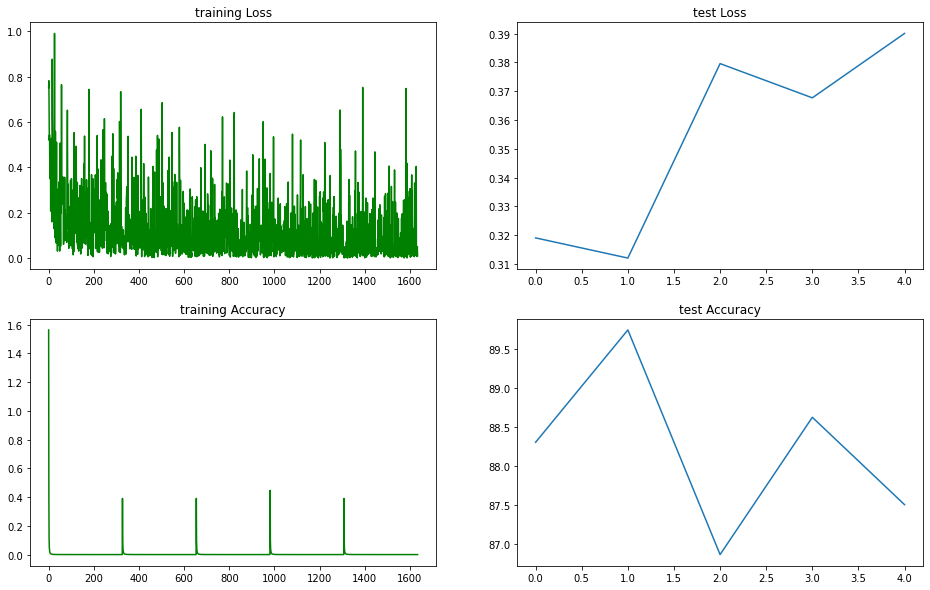

In [81]:
fig, axs = plt.subplots(2,2, figsize = (16, 10))
axs[0,0].plot(train_losses2, color = "green")
axs[0,0].set_title("training Loss")
axs[1,0].plot(train_acc2, color = "green")
axs[1,0].set_title("training Accuracy")
axs[0,1].plot(test_losses2)
axs[0,1].set_title("test Loss")
axs[1,1].plot(test_acc2)
axs[1,1].set_title("test Accuracy")

## Regulization

In [82]:
def train(model , device , train_loader, optimizer , epoch):
    model.train()
    pbar = tqdm(DataLoader_train)
    correct = 0
    processed = 0
    for batch_idx, (data, targets) in enumerate(pbar):
        #intializing the gradient
        #forward pass
        data = data.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        y_pred = model(data)
        loss = F.nll_loss(y_pred, targets)
        l1 = 0
        for p in model.parameters():
            l1 = l1+p.abs().sum()
        loss =  loss + l1  #using lambda = 1 
        train_losses.append(loss)
        
        #backward pass
        
        loss.backward()
        optimizer.step()
        pred = y_pred.argmax(dim = 1, keepdim = True)
        correct += pred.eq(targets.view_as(pred)).sum().item()
        processed += len(data)
        pbar.set_description( 
            desc = f"Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}")
        train_acc.append(100/correct/processed)
        
        

In [83]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

model = Convnet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9)
scheduler = StepLR(optimizer, step_size = 6, gamma = 0.5)

epochs = 5
for epoch in range(epochs):
    print("Epoch:" , epoch)
    train(model, device, DataLoader_train, optimizer, epoch)
    scheduler.step()
    print("current Learning Rate:" , optimizer.state_dict()["param_groups"][0]["lr"])
    test(model, device, DataLoader_test)

Epoch: 0


Loss=105.8530 Batch_id=326 Accuracy=52.37: 100%|██████████| 327/327 [01:59<00:00,  2.73it/s]


current Learning Rate: 0.01
Test set Average loss: 0.6933, Accuracy:37.5
Epoch: 1


Loss=100.8179 Batch_id=326 Accuracy=54.64: 100%|██████████| 327/327 [01:57<00:00,  2.77it/s]


current Learning Rate: 0.01
Test set Average loss: 0.6929, Accuracy:62.5
Epoch: 2


Loss=104.7721 Batch_id=326 Accuracy=49.37: 100%|██████████| 327/327 [01:58<00:00,  2.76it/s]


current Learning Rate: 0.01
Test set Average loss: 0.6935, Accuracy:37.5
Epoch: 3


Loss=97.9314 Batch_id=326 Accuracy=54.64: 100%|██████████| 327/327 [01:59<00:00,  2.74it/s] 


current Learning Rate: 0.01
Test set Average loss: 0.6928, Accuracy:62.5
Epoch: 4


Loss=104.9182 Batch_id=326 Accuracy=56.56: 100%|██████████| 327/327 [01:59<00:00,  2.74it/s]


current Learning Rate: 0.01
Test set Average loss: 0.6932, Accuracy:37.5


In [84]:
train_losses2 = [i.item() for i in train_losses]
train_acc2 = [i for i in train_acc]
test_losses2 = [i for i in test_losses]
test_acc2 = [i for i in test_acc]

Text(0.5, 1.0, 'test Accuracy')

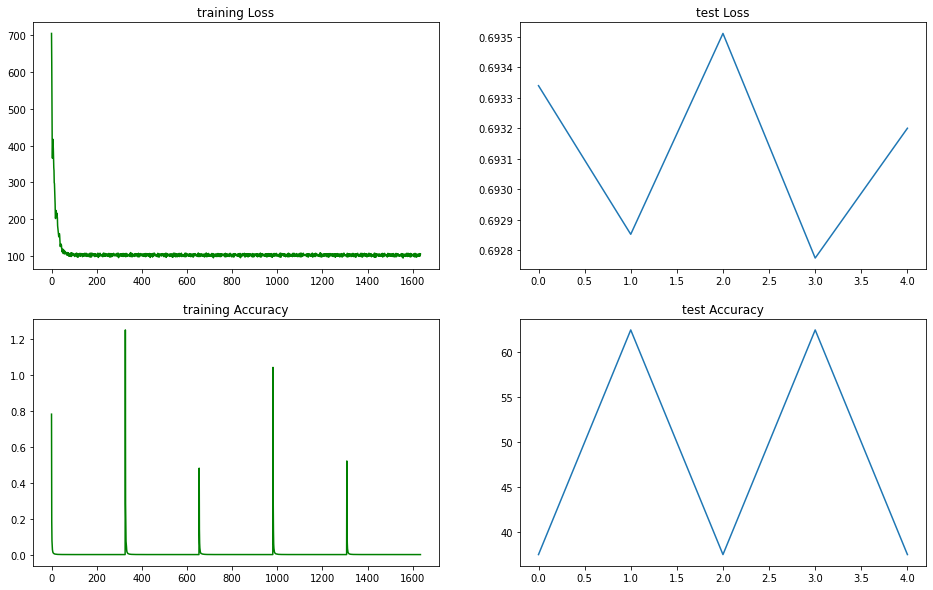

In [85]:
fig, axs = plt.subplots(2,2, figsize = (16, 10))
axs[0,0].plot(train_losses2, color = "green")
axs[0,0].set_title("training Loss")
axs[1,0].plot(train_acc2, color = "green")
axs[1,0].set_title("training Accuracy")
axs[0,1].plot(test_losses2)
axs[0,1].set_title("test Loss")
axs[1,1].plot(test_acc2)
axs[1,1].set_title("test Accuracy")